In [11]:
import os
import re
import time

import torch
import numpy as np

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.plotting import plot_ref_obs_states, pcd_plot
from quadrotor_diffusion.utils.trajectory import derive_trajectory, integrate_trajectory

In [12]:
experiment = 21
epoch = 19
EMA = True
device = "cuda:2"

In [13]:
train_dir = "../logs/training"

folders = os.listdir(train_dir)
training_folder = None
for folder in folders:
    if folder.startswith(f"{experiment}."):
        training_folder = folder
        break

if training_folder is None:
    raise NameError(f"No folder found for experiment {experiment}")
training_folder = os.path.join(train_dir, training_folder)
checkpoint_folder = os.path.join(training_folder, "checkpoints")

pattern = r'epoch_(\d+)_loss_([\d.]+)'
checkpoints = dict()

for file in os.listdir(checkpoint_folder):
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        checkpoints[epoch] = os.path.join(checkpoint_folder, file)

if not len(checkpoints.keys()):
    raise ValueError("No epoch files found.")

checkpoint_file = None
if epoch is None:
    checkpoint_file = checkpoints[max(checkpoints.keys())]
elif epoch in checkpoints:
    checkpoint_file = checkpoints[epoch]
else:
    raise ValueError(f"Epoch {epoch} not found.")

exp_dir_base = os.path.join(training_folder, "experiments")
if not os.path.exists(exp_dir_base):
    os.mkdir(exp_dir_base)

max_exp_num = 0
pattern = re.compile(rf"exp_(\d+)")

for entry in os.listdir(exp_dir_base):
    match = pattern.match(entry)
    if match:
        e_value = int(match.group(1))
        max_exp_num = max(max_exp_num, e_value)

exp_dir = os.path.join(exp_dir_base, f"exp_{max_exp_num + 1}")
os.mkdir(exp_dir)
with open(os.path.join(exp_dir, "overview.txt"), "w") as f:
    f.write(
        f"Epoch: {max(checkpoints.keys()) if epoch is None else epoch}\n" +
        ("Using EMA\n" if EMA else "Not using EMA\n") +
        f"Device: {device}\n"
    )


In [14]:
model: VAE_Wrapper = None
ema: VAE_Wrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

diff, ema, normalizer, trainer_args = Trainer.load(checkpoint_file)
model = diff if EMA else ema
model.to(device)
print(f"Loaded {checkpoint_file}")

Loaded ../logs/training/21.VAE_Wrapper.Nov.18_09:53_PM/checkpoints/epoch_14_loss_0.0002


/u/cbf2xv/quadrotor-sim/quadrotor_diffusion/quadrotor_diffusion/utils/nn/training.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filepath)


In [15]:
def encode(SAMPLE_NUM):
    ref_pos = np.load(f"../data/quadrotor_random/{SAMPLE_NUM}.npy")
    
    ref_acc = derive_trajectory(ref_pos, 30, order=3)
    ref_acc_normalized = normalizer(ref_acc)

    ref_acc_normalized = torch.tensor(ref_acc_normalized).float()
    ref_acc_normalized = ref_acc_normalized.unsqueeze(0)
    ref_acc_normalized = ref_acc_normalized.to(device)

    mu, logvar = model.encode(ref_acc_normalized)
    return mu, logvar

def decode(SAMPLE_NUM, mu):
    ref_pos = np.load(f"../data/quadrotor_random/{SAMPLE_NUM}.npy")
    
    ref_acc_normalized_recon = model.decode(mu)
    
    ref_acc_normalized_recon = ref_acc_normalized_recon.squeeze(0).cpu().numpy()
    ref_acc_recon = normalizer.undo(ref_acc_normalized_recon)
    ref_vel_recon = integrate_trajectory(ref_acc_recon, 30)
    ref_pos_recon = integrate_trajectory(ref_vel_recon, 30, initial_conditions=ref_pos[0])
    
    return (
        ref_pos,
        derive_trajectory(ref_pos, 30),
        derive_trajectory(ref_pos, 30, order=3),
        ref_pos_recon,
        ref_vel_recon,
        ref_acc_recon,
    )

def recon_sample(SAMPLE_NUM):
    mu, _ = encode(SAMPLE_NUM)
    data = decode(SAMPLE_NUM, mu)
    
    plot_ref_obs_states(
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
        None,
        os.path.join(exp_dir, f"vae_{SAMPLE_NUM}.pdf"),
    )

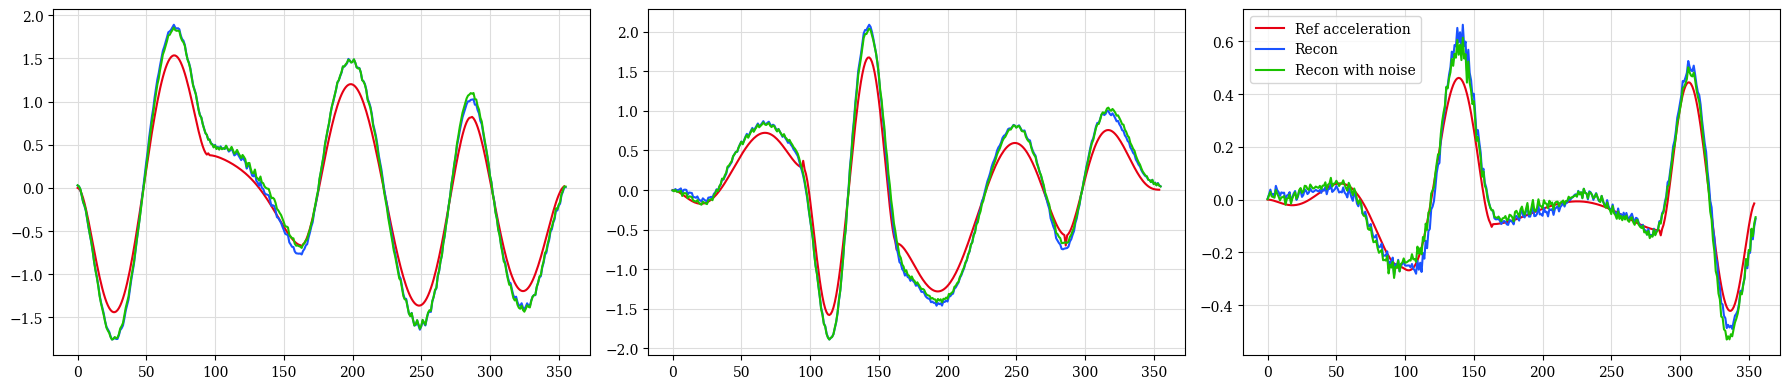

In [16]:
from random import randint
sample = randint(0, 18000)
mu, logvar = encode(sample)
n_mu = mu + 0.1 * torch.randn_like(mu)
# std = torch.exp(0.5 * logvar)
# epsilon = torch.randn_like(std)
# n_mu = mu + std * epsilon

results_0 = decode(sample, mu)
results_1 = decode(sample, n_mu)

base_a = results_0[2]
res_0_a = results_0[-1]
res_1_a = results_1[-1]

import matplotlib.pyplot as plt


plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.grid()
plt.plot(base_a[:, 0], label='Ref acceleration')
plt.plot(res_0_a[:, 0], label='Recon')
plt.plot(res_1_a[:, 0], label='Recon with noise')
plt.subplot(132)
plt.grid()
plt.plot(base_a[:, 1], label='Ref acceleration')
plt.plot(res_0_a[:, 1], label='Recon')
plt.plot(res_1_a[:, 1], label='Recon with noise')
plt.subplot(133)
plt.grid()
plt.plot(base_a[:, 2], label='Ref acceleration')
plt.plot(res_0_a[:, 2], label='Recon')
plt.plot(res_1_a[:, 2], label='Recon with noise')
plt.tight_layout()
plt.legend()
plt.show()


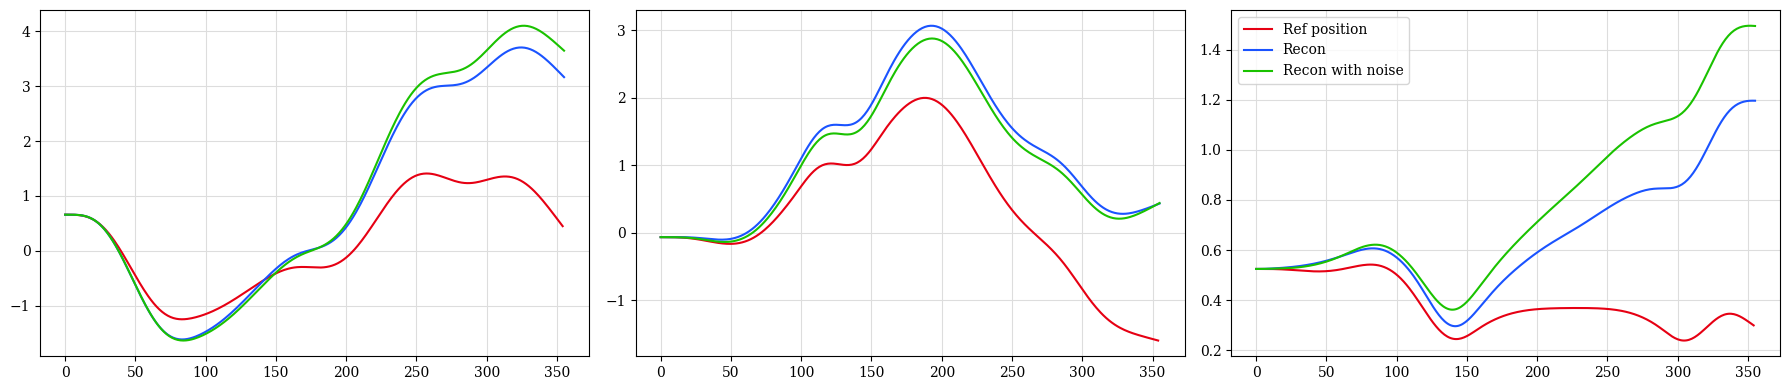

In [17]:
base_p = results_0[0]
res_0_p = results_0[-3]
res_1_p = results_1[-3]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(base_p[:, 0], label='Ref position')
plt.plot(res_0_p[:, 0], label='Recon')
plt.plot(res_1_p[:, 0], label='Recon with noise')
plt.grid()
plt.subplot(132)
plt.plot(base_p[:, 1], label='Ref position')
plt.plot(res_0_p[:, 1], label='Recon')
plt.plot(res_1_p[:, 1], label='Recon with noise')
plt.grid()
fig = plt.subplot(133)
plt.plot(base_p[:, 2], label='Ref position')
plt.plot(res_0_p[:, 2], label='Recon')
plt.plot(res_1_p[:, 2], label='Recon with noise')
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()


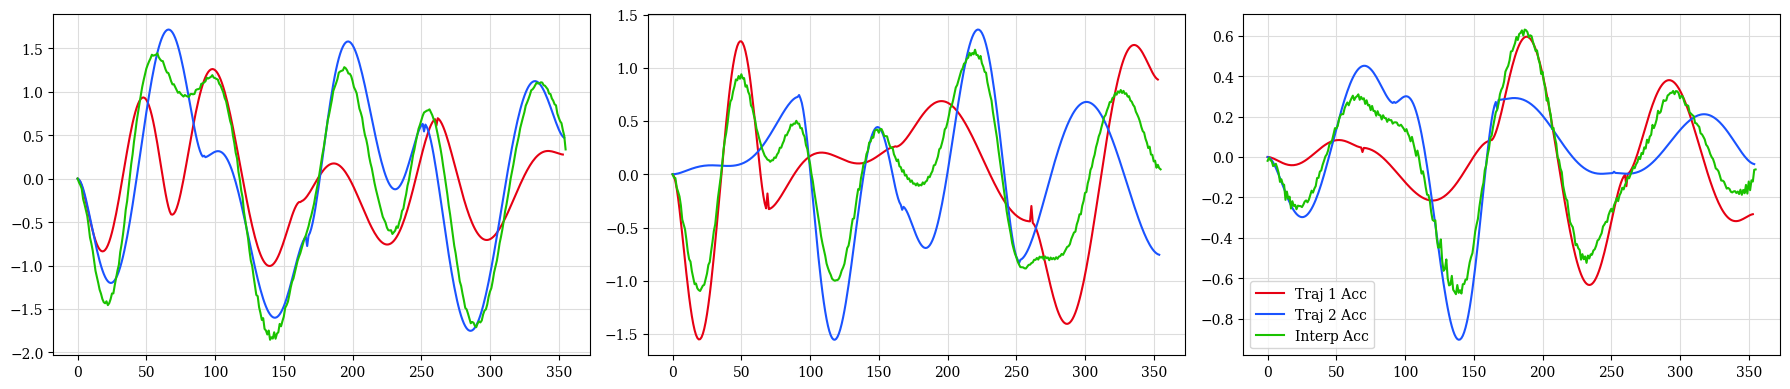

In [18]:
from random import randint
sample0 = randint(0, 18000)
sample1 = randint(0, 18000)

mu0, _ = encode(sample0)
mu1, _ = encode(sample1)
mu_1_5 = 0.5 * mu0 + 0.5 * mu1

results_0 = decode(sample0, mu0)
results_1 = decode(sample1, mu1)
results_1_5 = decode(sample0, mu_1_5)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.grid()
plt.plot(results_0[2][:, 0], label='Traj 1 Acc')
plt.plot(results_1[2][:, 0], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 0], label='Interp Acc')
plt.subplot(132)
plt.grid()
plt.plot(results_0[2][:, 1], label='Traj 1 Acc')
plt.plot(results_1[2][:, 1], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 1], label='Interp Acc')
plt.subplot(133)
plt.grid()
plt.plot(results_0[2][:, 2], label='Traj 1 Acc')
plt.plot(results_1[2][:, 2], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 2], label='Interp Acc')
plt.tight_layout()
plt.legend()
plt.show()


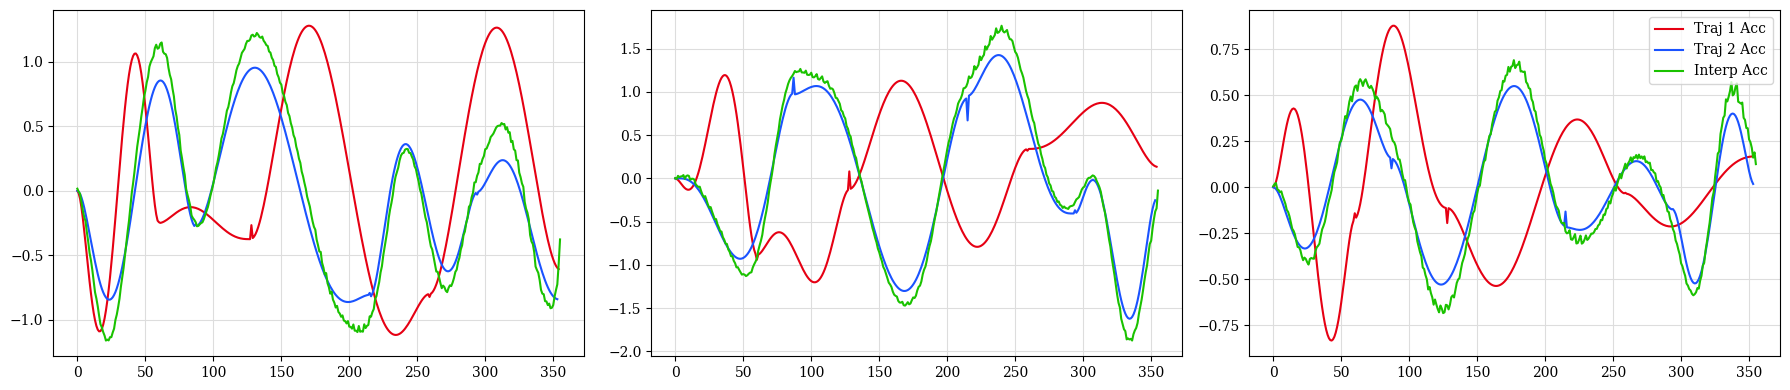

In [19]:
from random import randint
sample0 = randint(0, 18000)
sample1 = randint(0, 18000)

mu0, _ = encode(sample0)
mu1, _ = encode(sample1)
mu_1_5 = 0.1 * mu0 + 0.9 * mu1

results_0 = decode(sample0, mu0)
results_1 = decode(sample1, mu1)
results_1_5 = decode(sample0, mu_1_5)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.grid()
plt.plot(results_0[2][:, 0], label='Traj 1 Acc')
plt.plot(results_1[2][:, 0], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 0], label='Interp Acc')
plt.subplot(132)
plt.grid()
plt.plot(results_0[2][:, 1], label='Traj 1 Acc')
plt.plot(results_1[2][:, 1], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 1], label='Interp Acc')
plt.subplot(133)
plt.grid()
plt.plot(results_0[2][:, 2], label='Traj 1 Acc')
plt.plot(results_1[2][:, 2], label='Traj 2 Acc')
plt.plot(results_1_5[-1][:, 2], label='Interp Acc')
plt.tight_layout()
plt.legend()
plt.show()


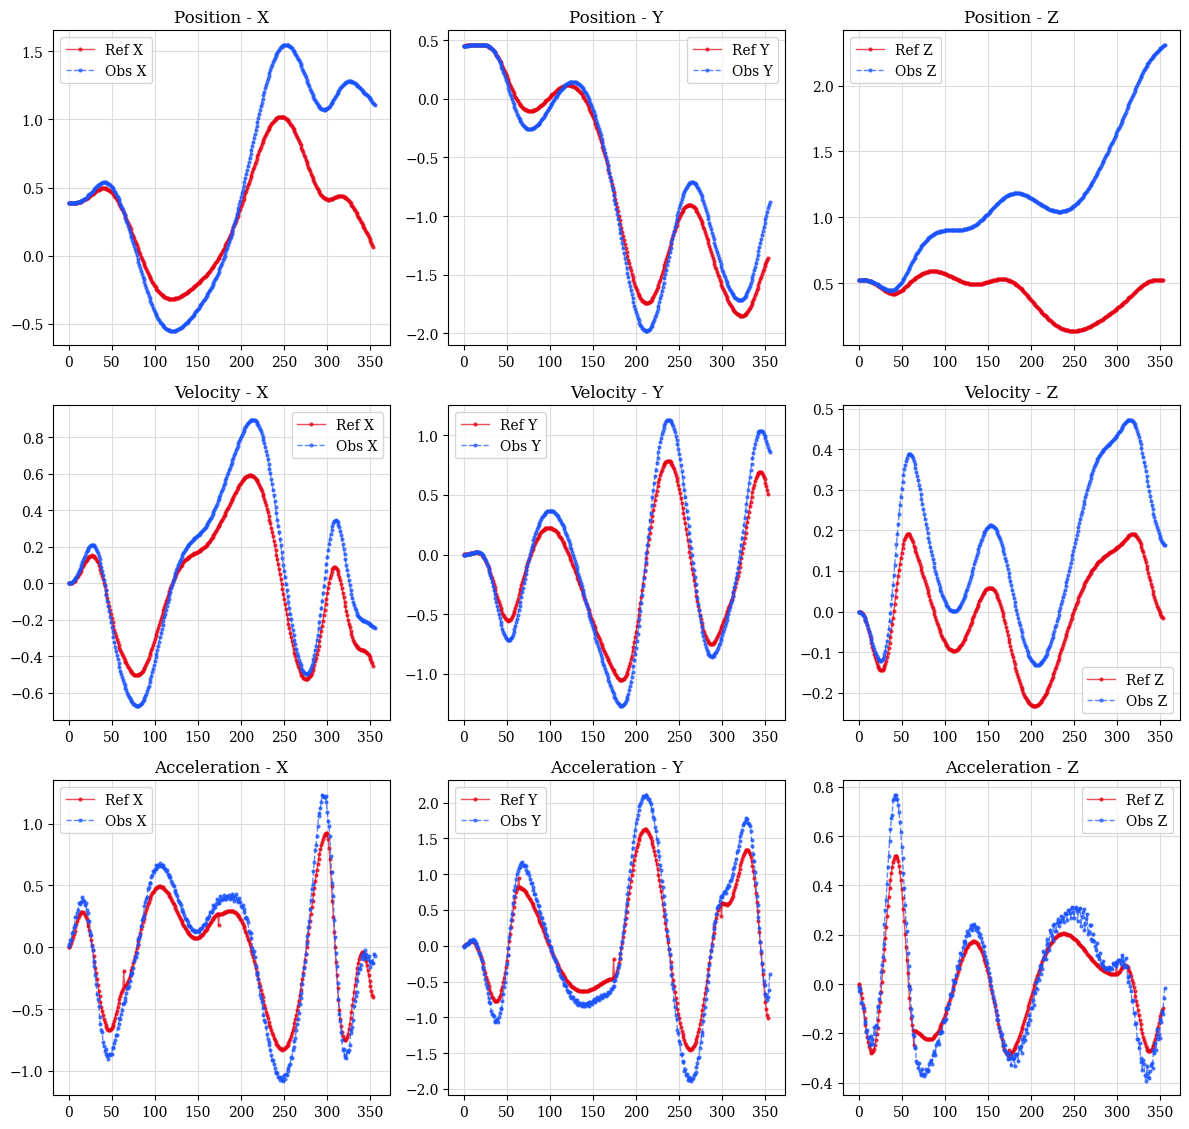

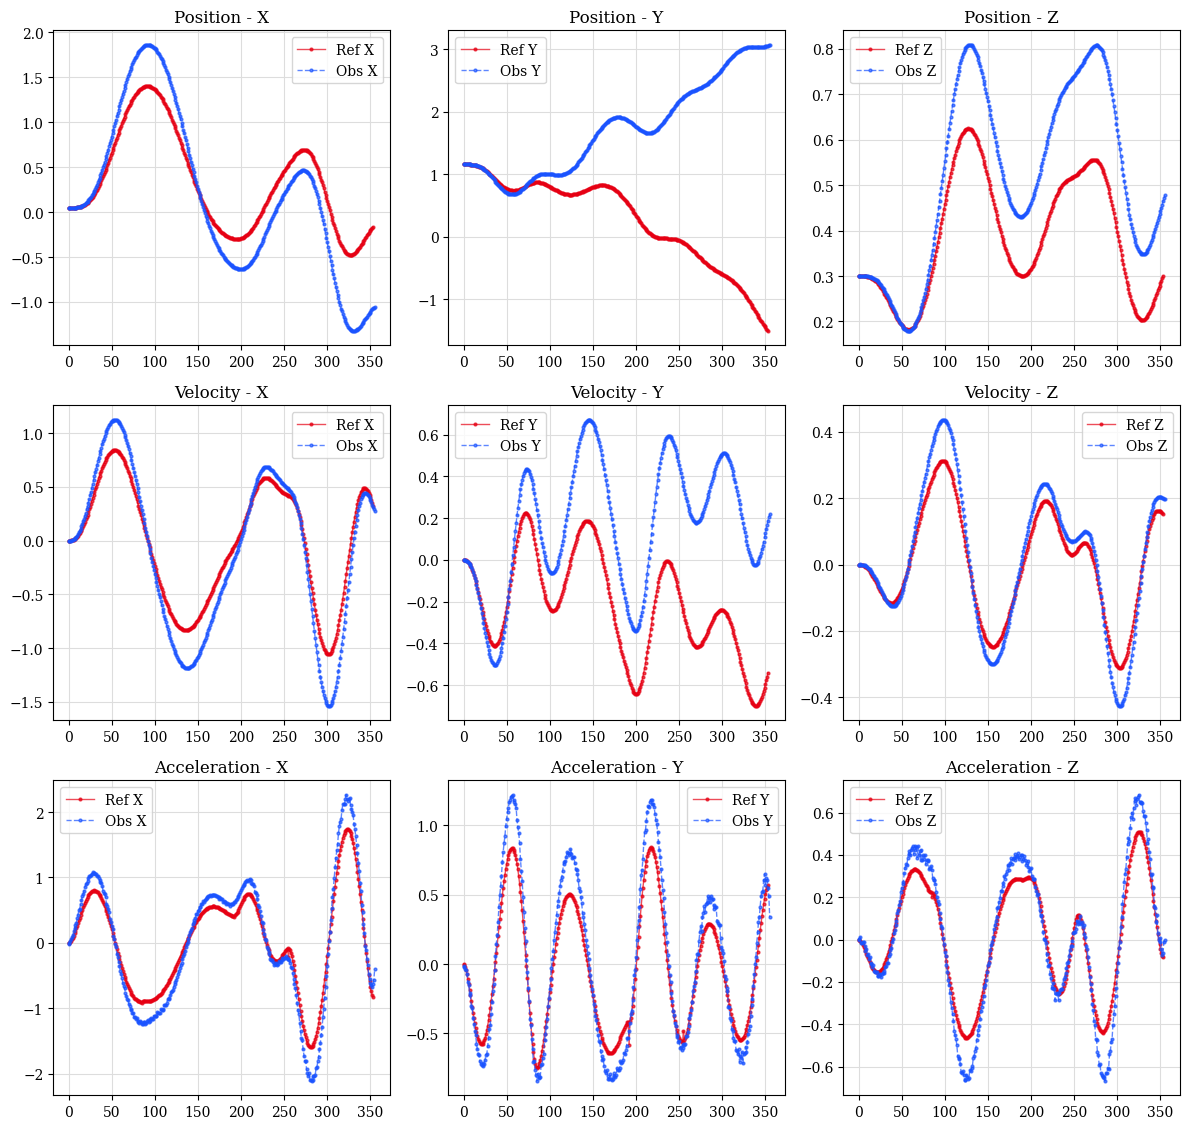

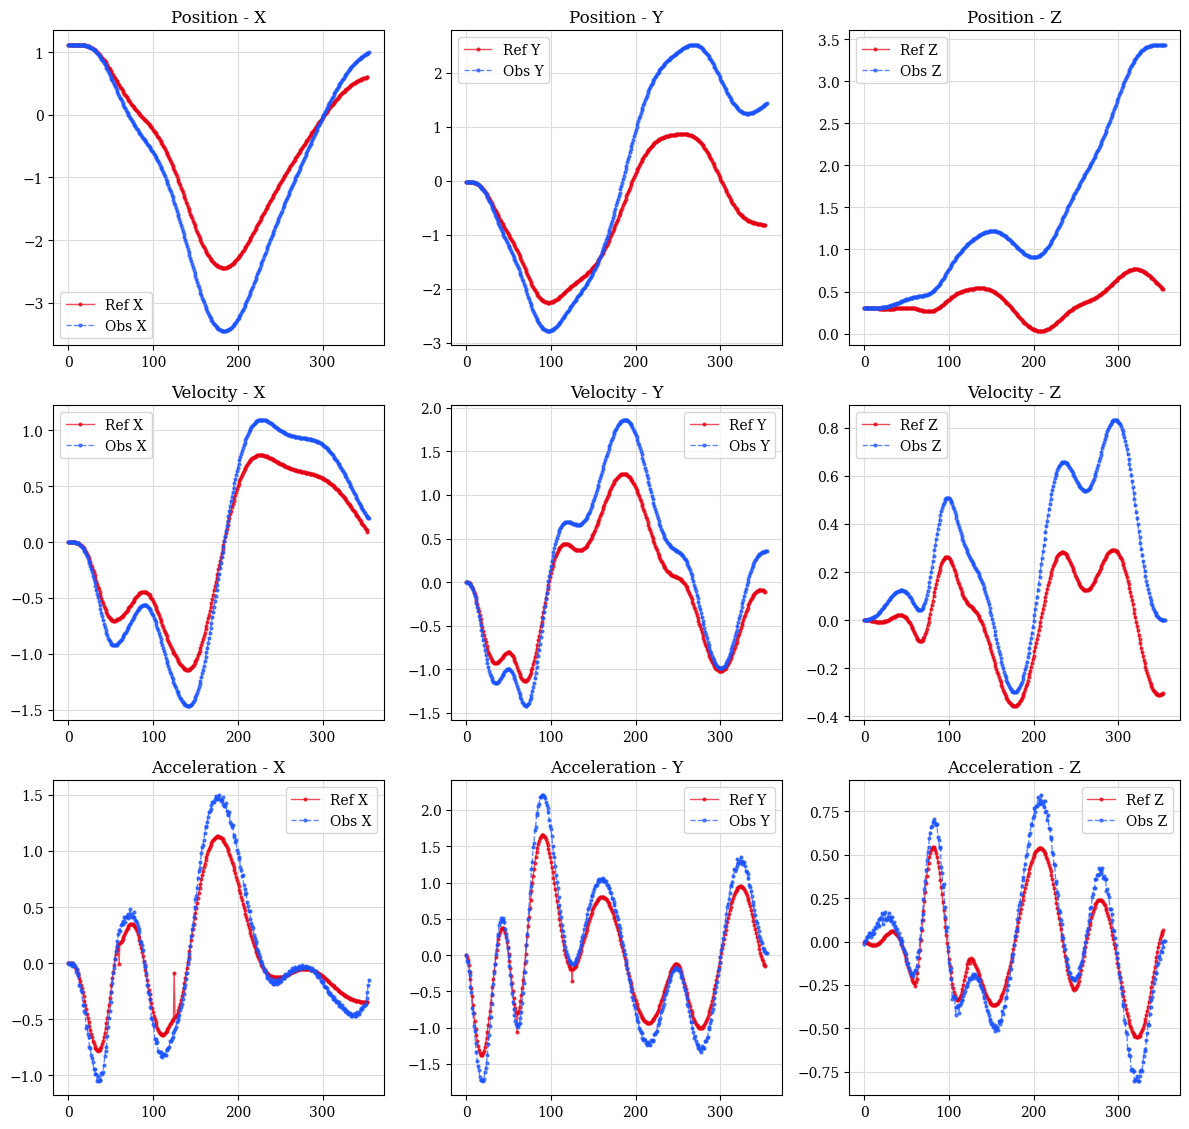

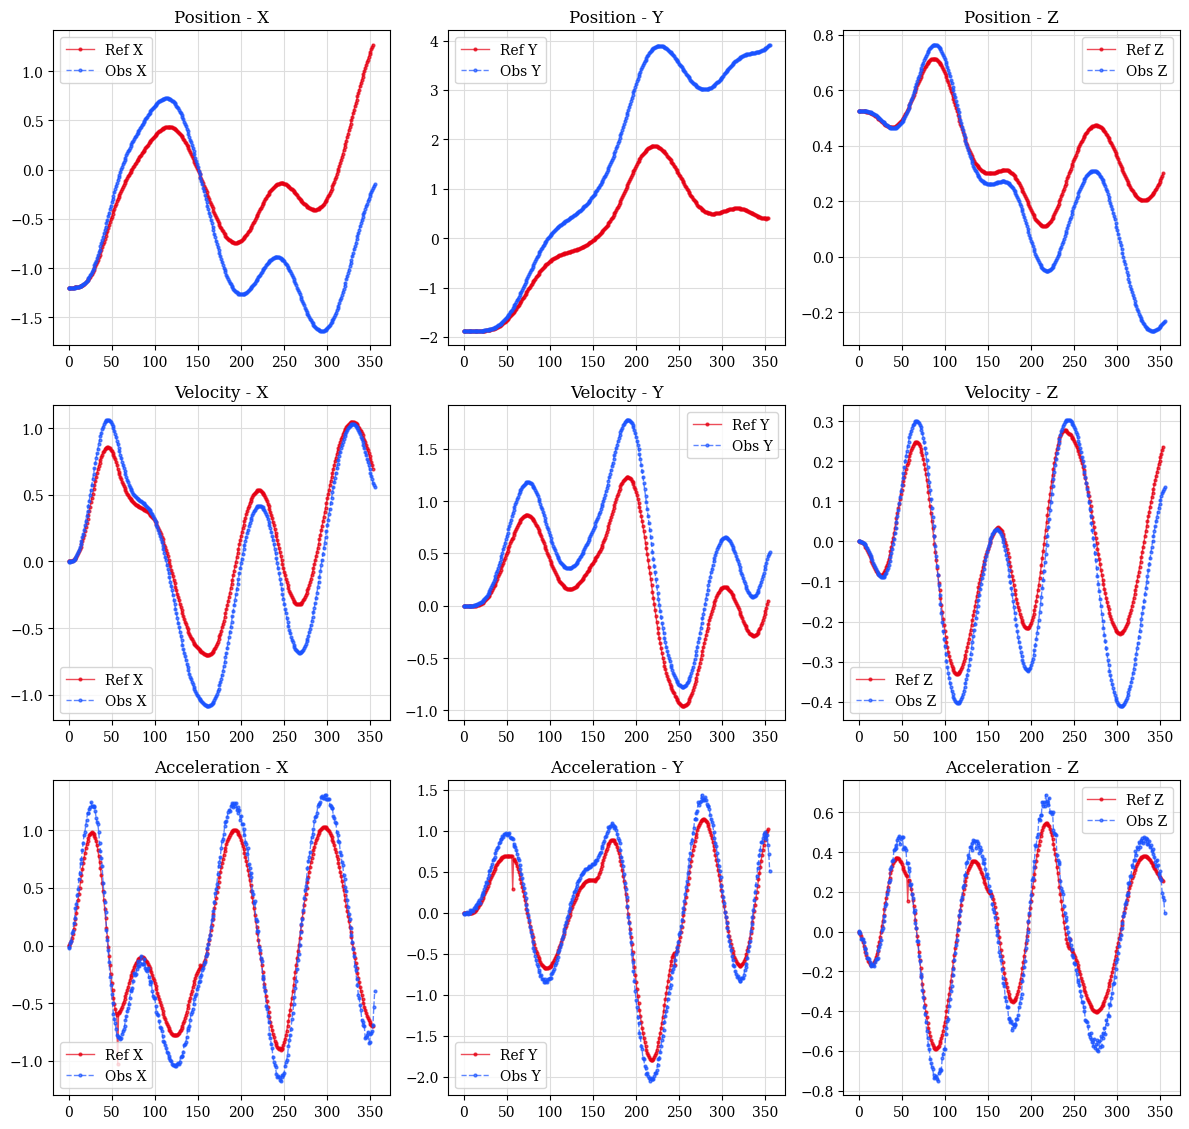

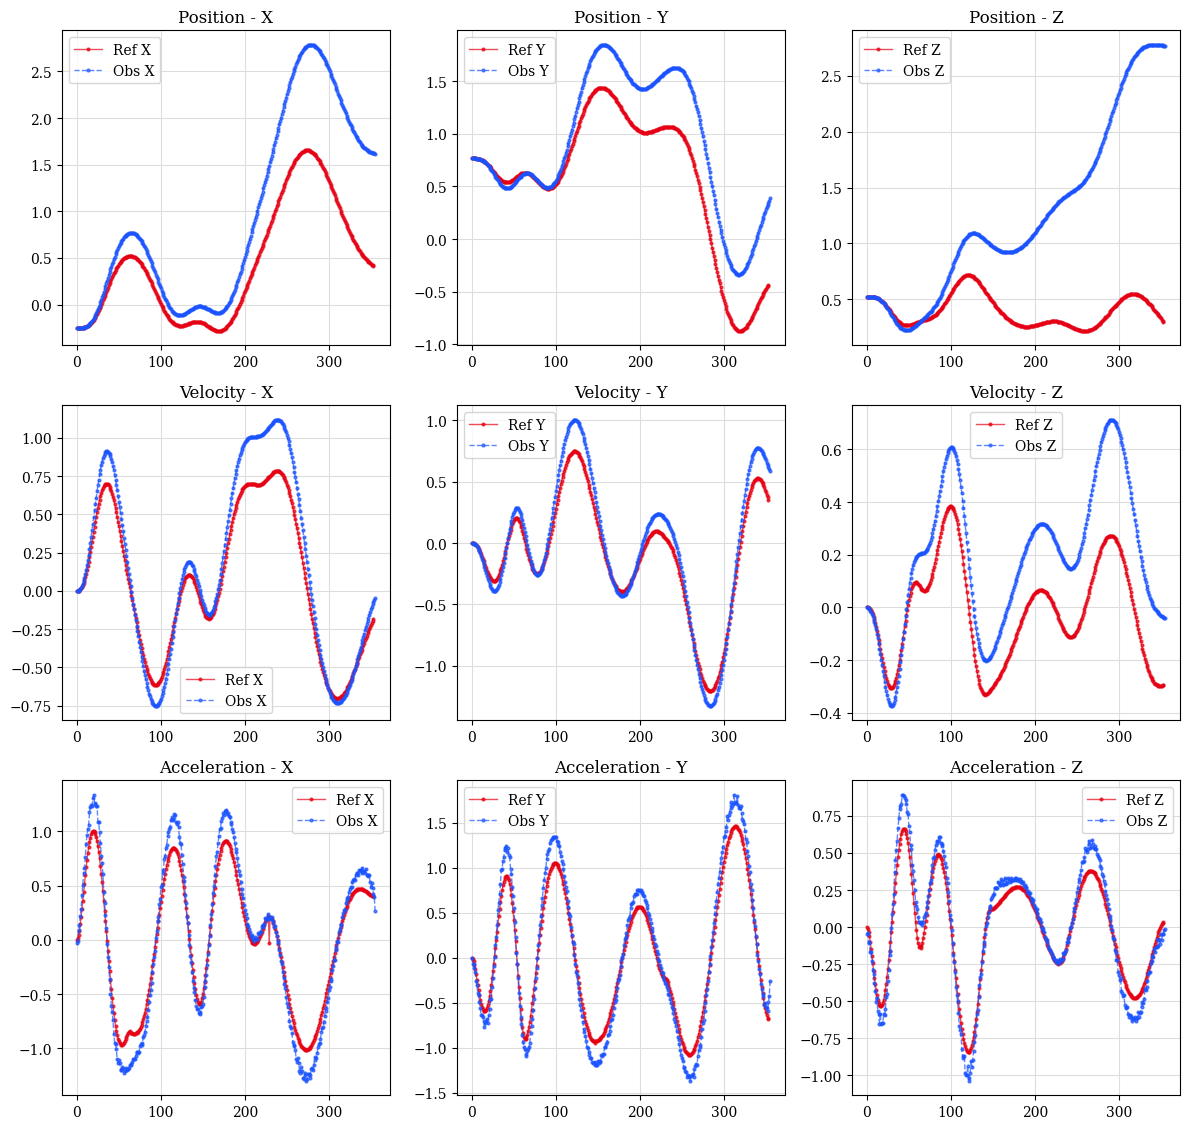

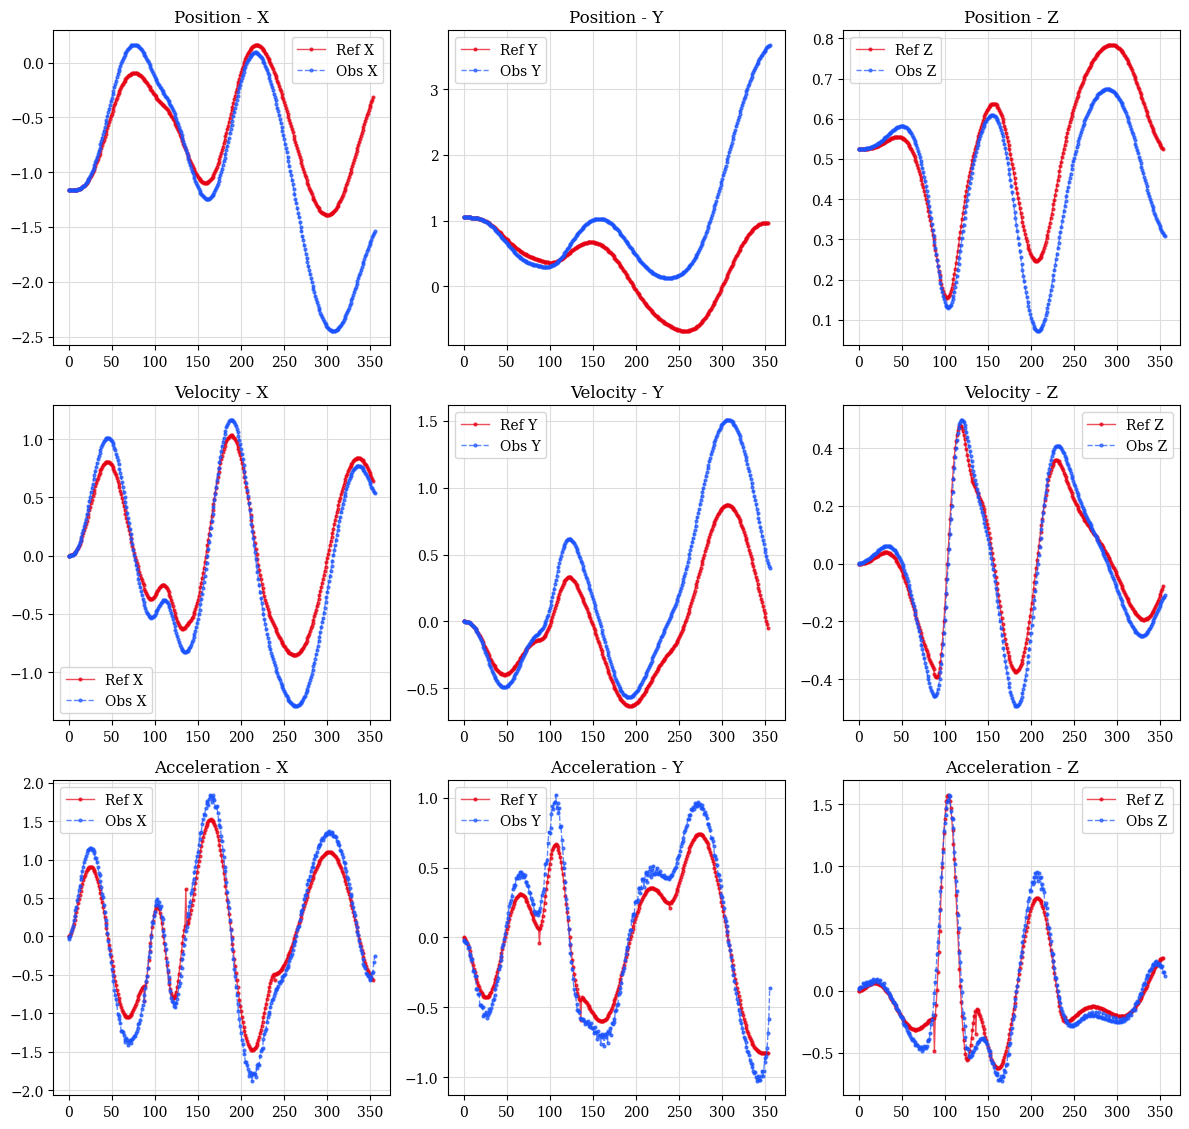

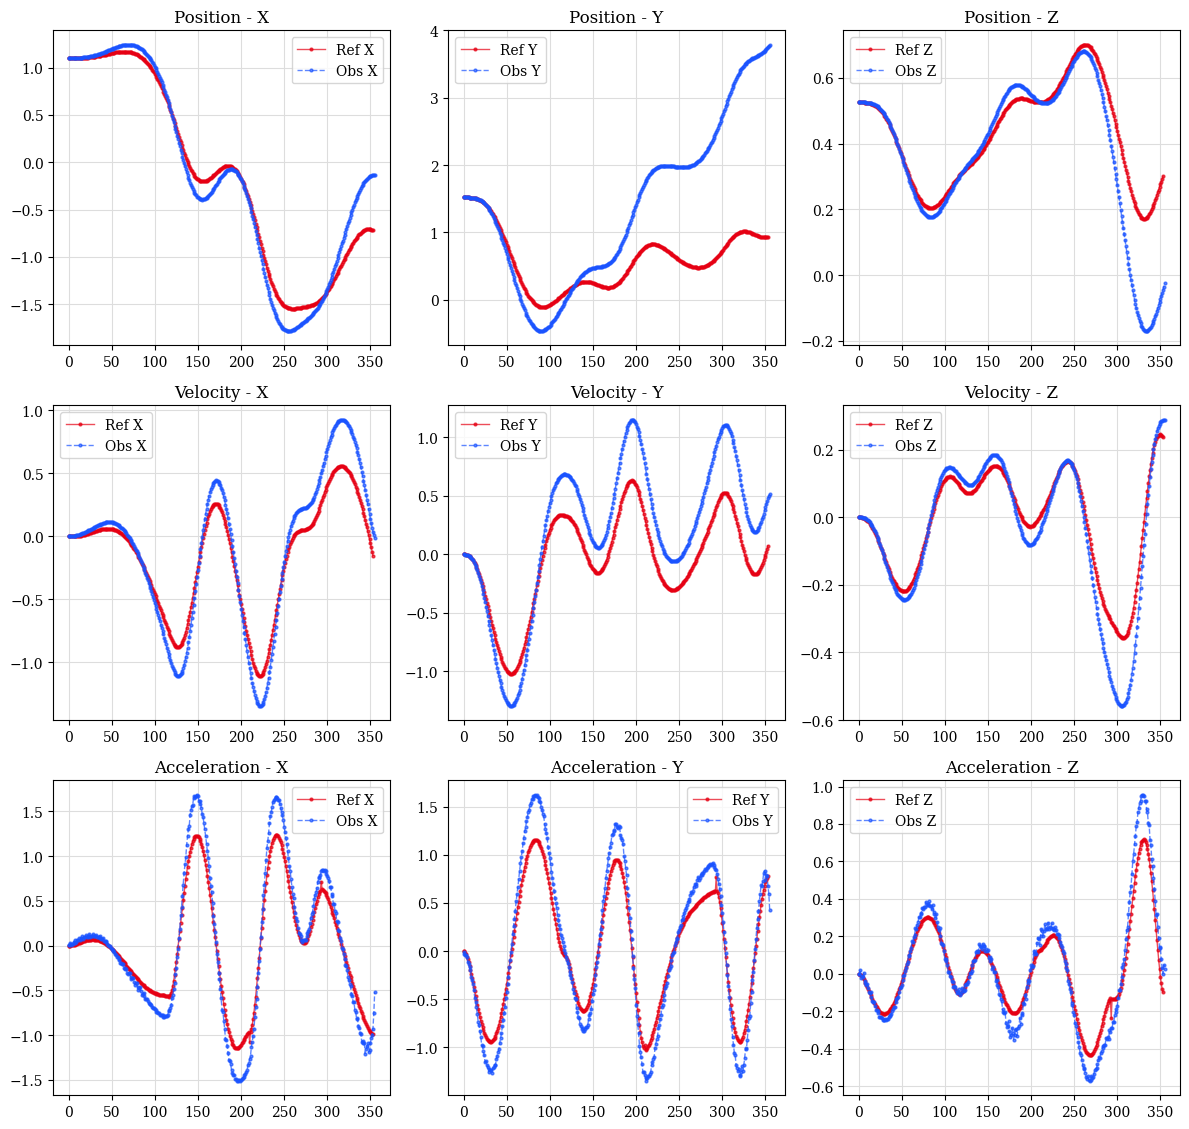

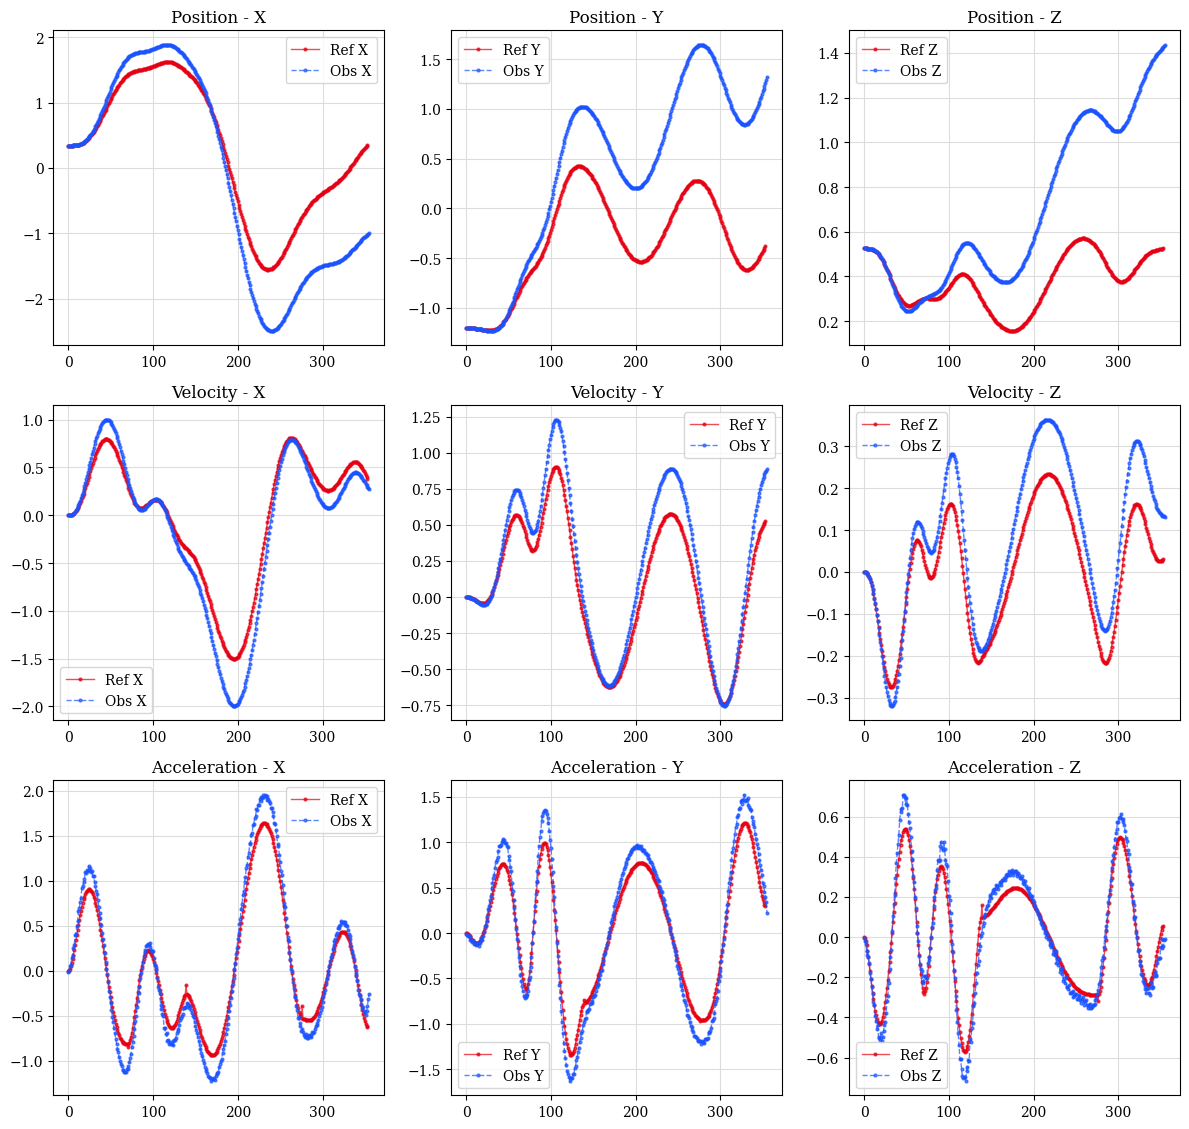

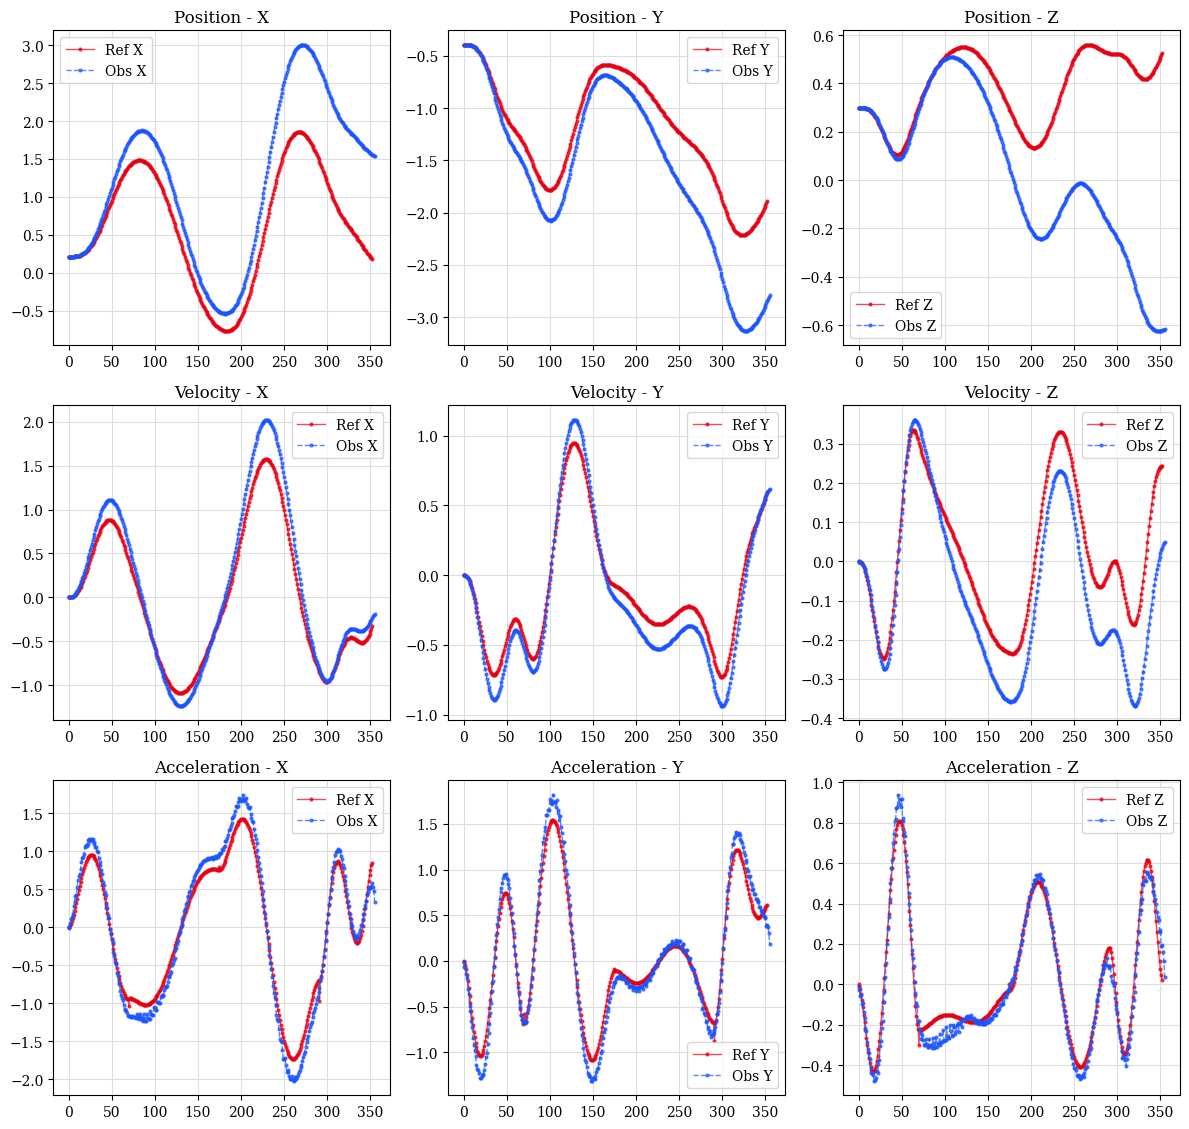

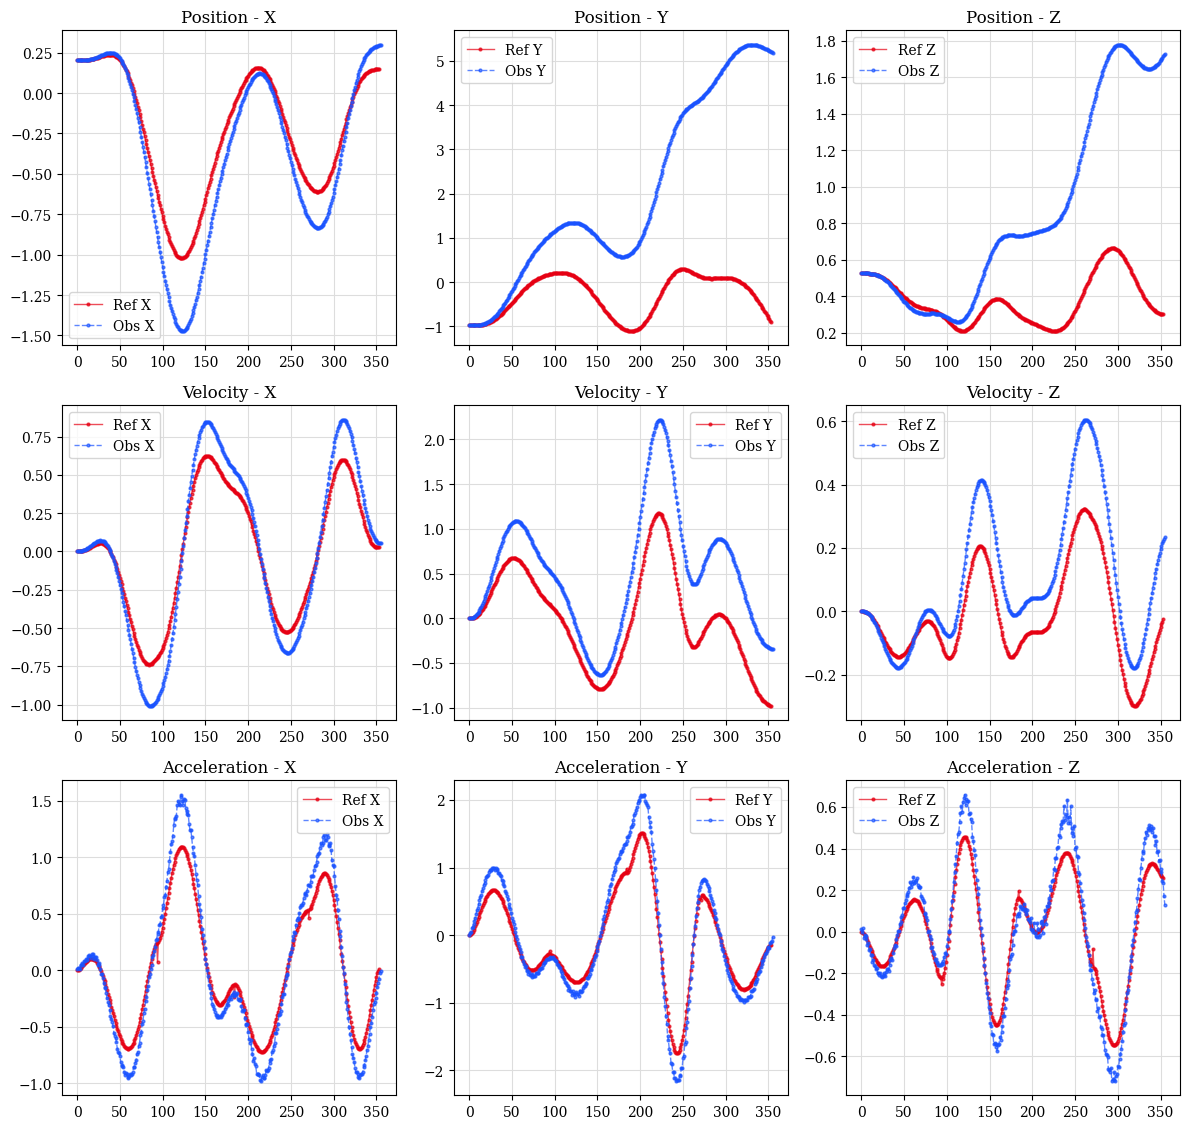

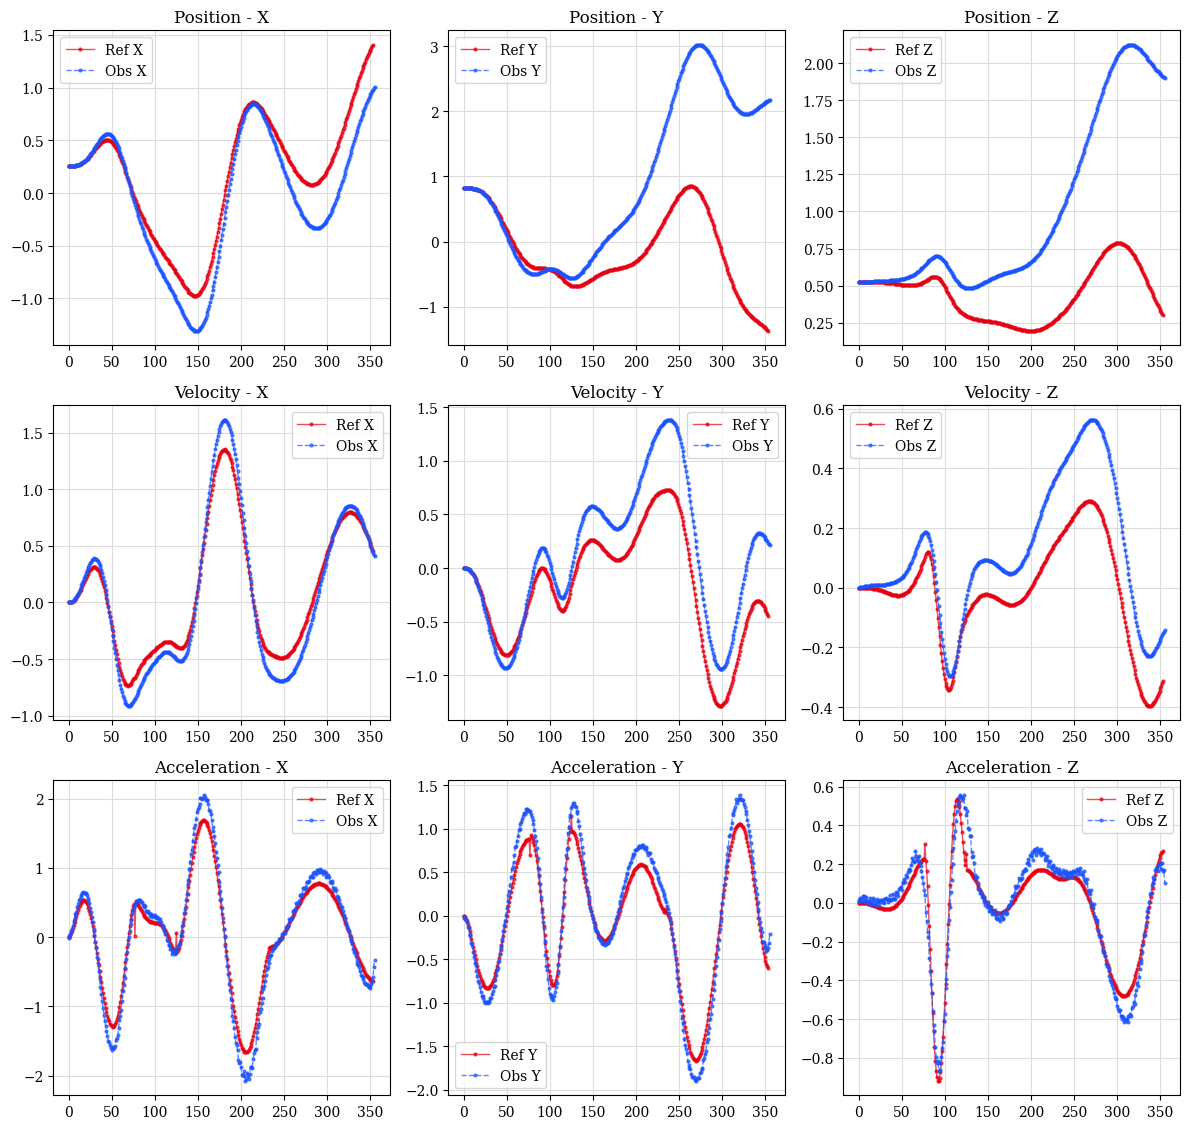

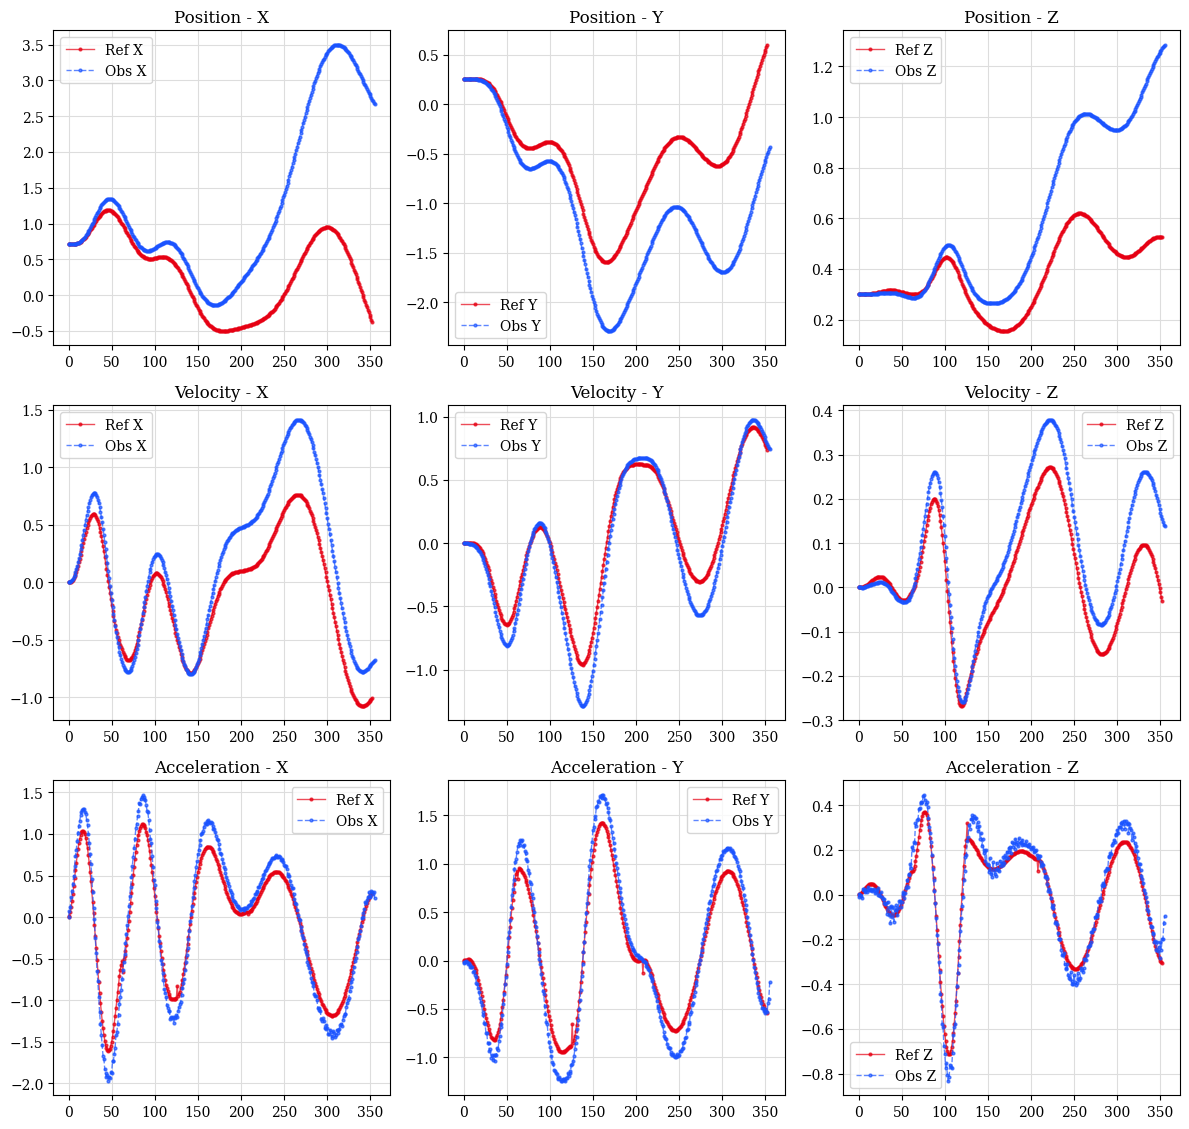

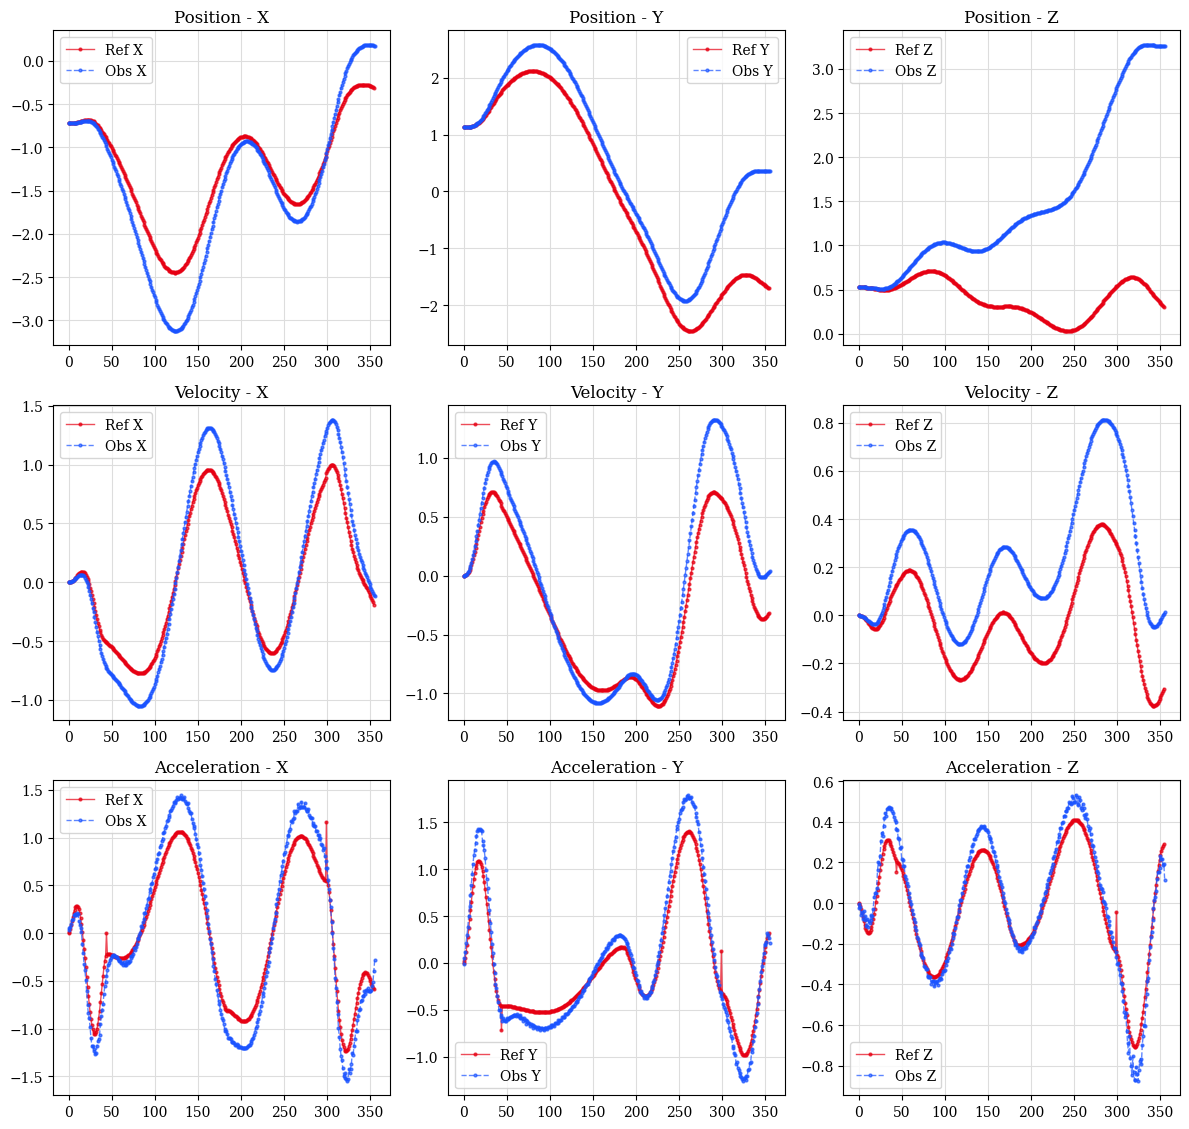

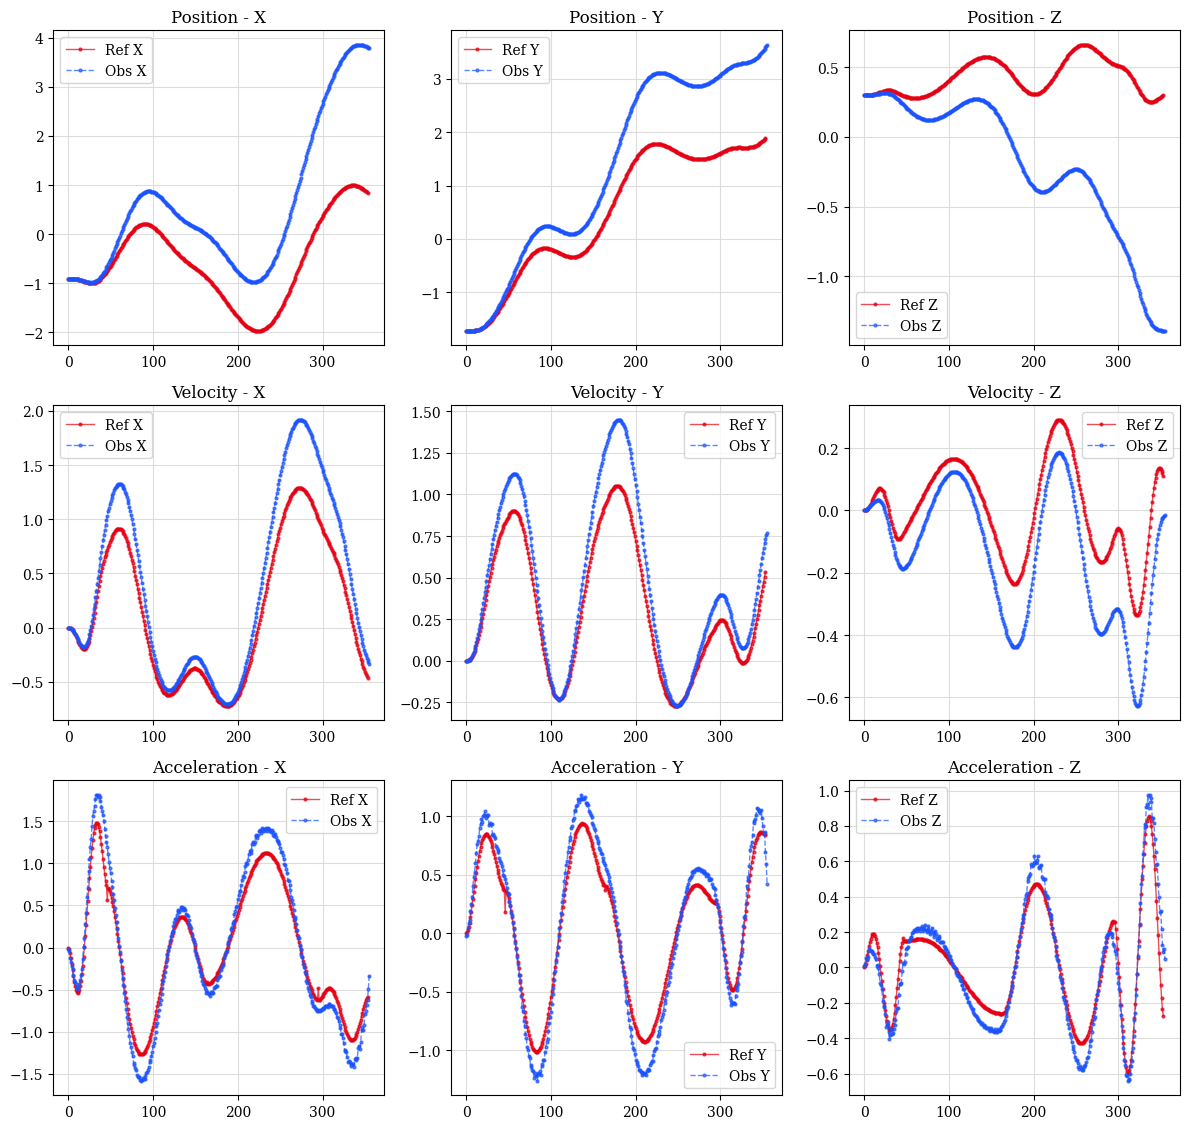

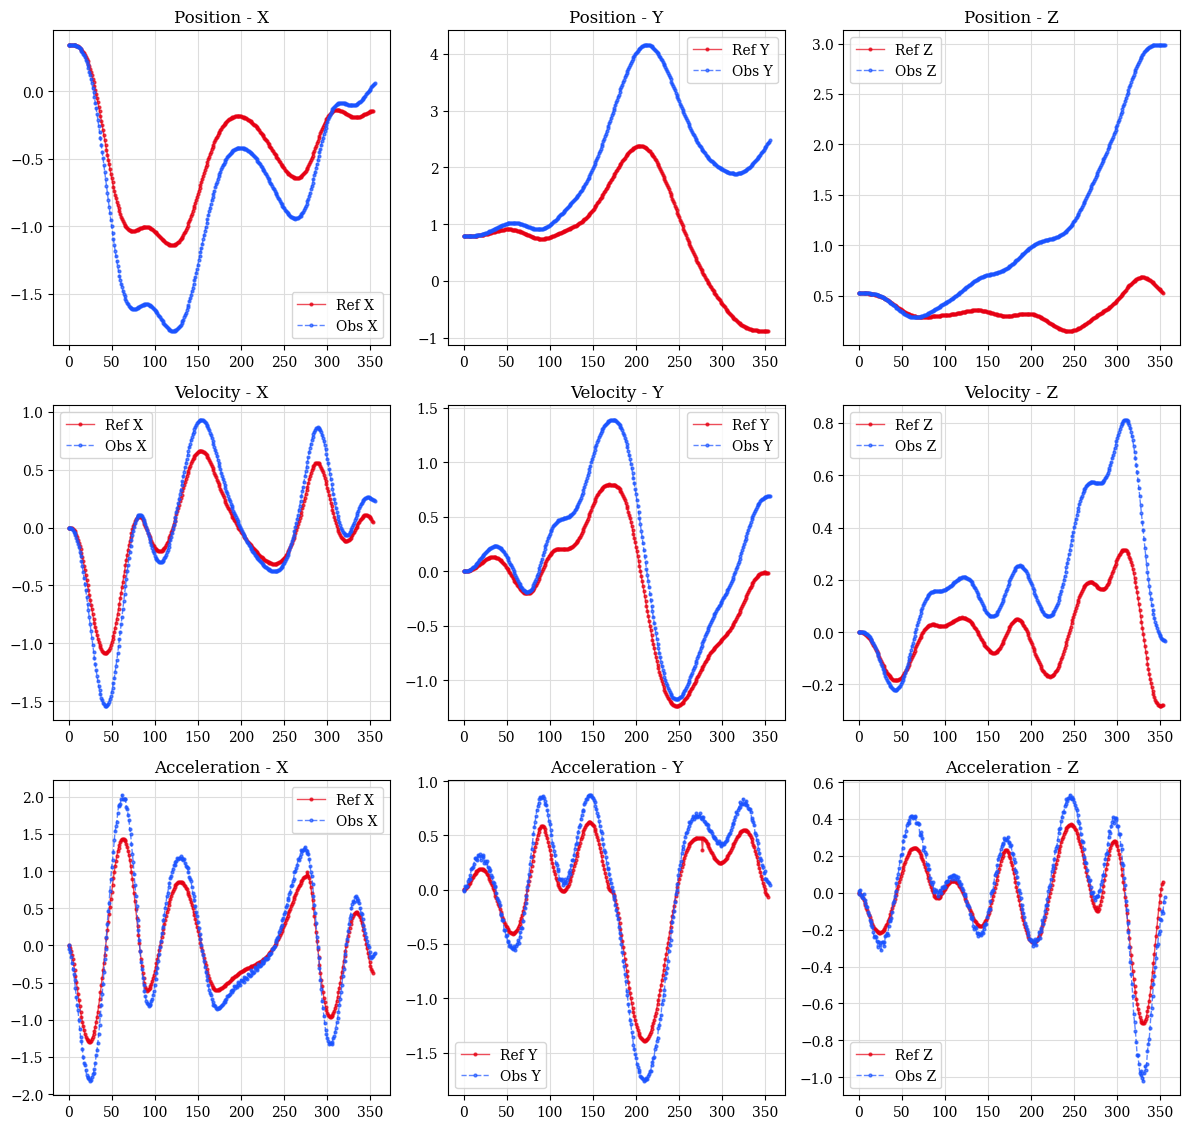

In [20]:
for _ in range(15):
    sample = randint(0, 18000)
    recon_sample(sample)